In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("academic_success_dataset.csv")
df = df.drop(columns=["Unnamed: 25", "Unnamed: 26"], errors='ignore')
df = df.dropna(subset=["Target"])
df.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Unemployment rate,Inflation rate,GDP,Target
0,1.0,17.0,5.0,171.0,1.0,1.0,122.0,1.0,19.0,12.0,...,0.0,1.0,1.0,0.0,NaN,0.0,10.8,1.4,1.74,Dropout
1,1.0,15.0,1.0,9254.0,1.0,1.0,160.0,1.0,1.0,3.0,...,0.0,0.0,1.0,0.0,19.0,0.0,13.9,-0.3,0.79,Graduate
2,1.0,NaN,5.0,9070.0,1.0,1.0,122.0,NaN,37.0,37.0,...,0.0,0.0,1.0,NaN,19.0,0.0,10.8,1.4,1.74,Dropout
3,1.0,17.0,2.0,9773.0,1.0,1.0,122.0,1.0,38.0,37.0,...,0.0,1.0,NaN,0.0,20.0,0.0,9.4,-0.8,-3.12,Graduate
4,2.0,39.0,1.0,8014.0,0.0,1.0,100.0,1.0,37.0,NaN,...,0.0,1.0,0.0,0.0,NaN,0.0,13.9,-0.3,0.79,Graduate


Numerical features: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate', 'Inflation rate', 'GDP']
Categorical features: ['Target']


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


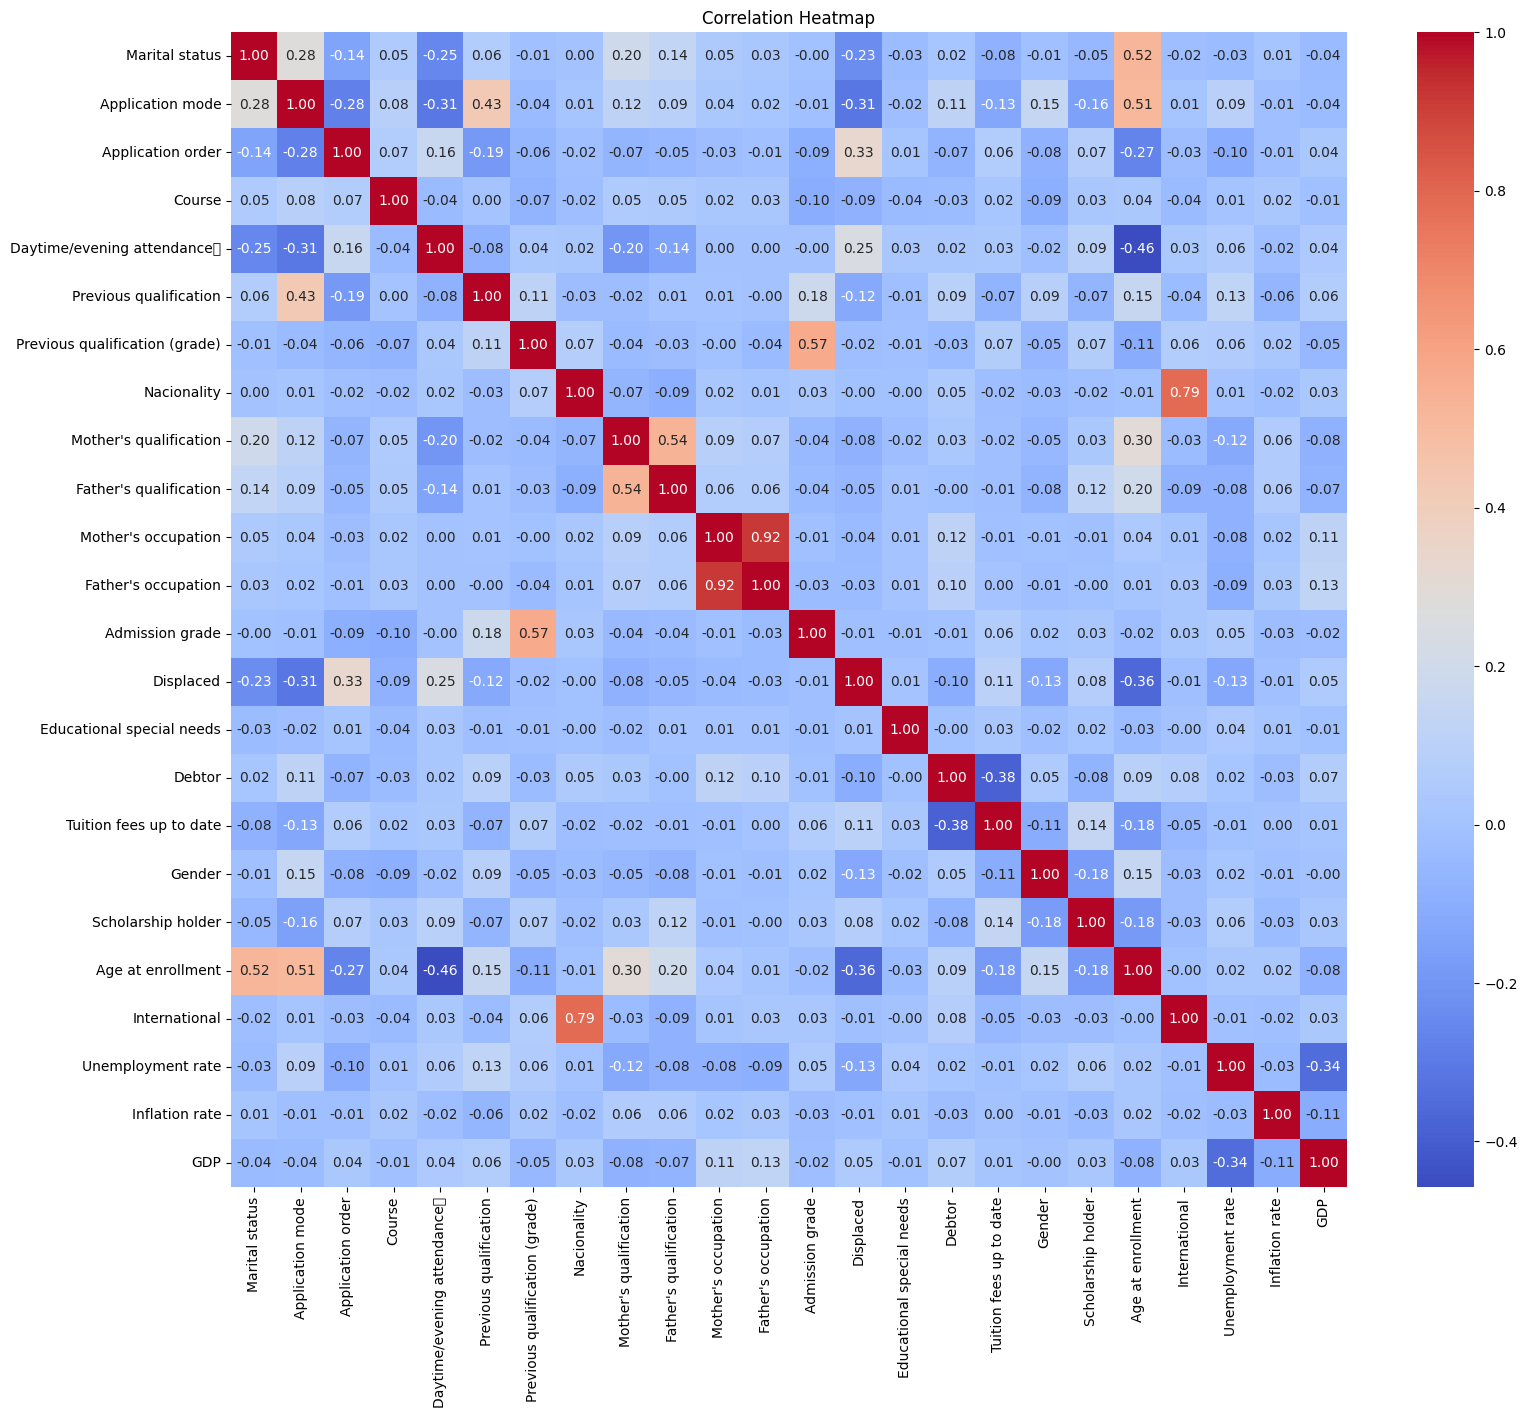

In [5]:

numerical = df.select_dtypes(include="number")
categorical = df.select_dtypes(include="object")

print(f"Numerical features: {numerical.columns.tolist()}")
print(f"Categorical features: {categorical.columns.tolist()}")

plt.figure(figsize=(18, 15))
sns.heatmap(numerical.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


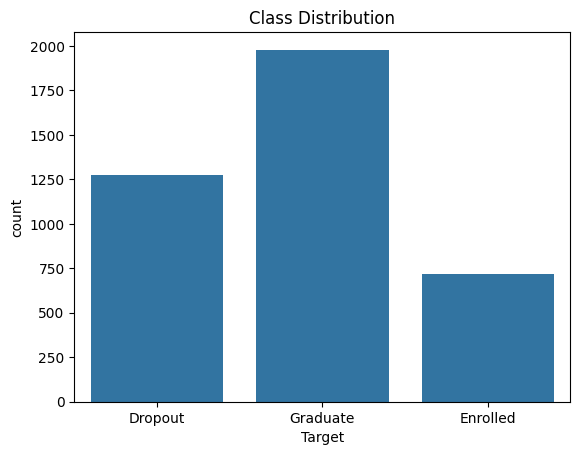

In [6]:

sns.countplot(x="Target", data=df)
plt.title("Class Distribution")
plt.show()


In [7]:

from sklearn.impute import SimpleImputer

# Fill missing values
for col in df.select_dtypes(include="number").columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include="object").columns.drop("Target"):
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode target
df["Target"] = df["Target"].astype("category")
target_mapping = dict(enumerate(df["Target"].cat.categories))
df["Target"] = df["Target"].cat.codes


In [8]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

X = df.drop("Target", axis=1)
y = df["Target"]

numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_features),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]), categorical_features)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_processed, y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=50 is greater than n_features=24. All the features will be returned.
  warnings.warn(


In [13]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=15, min_samples_split=4, class_weight='balanced', random_state=42),
    "Neural Network": MLPClassifier(
    hidden_layer_sizes=(300, 200, 100),
    activation='relu',
    solver='adam',
    alpha=0.0005,
    learning_rate_init=0.0005,
    max_iter=2000,
    early_stopping=True,
    random_state=42
)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f"Model: {name}\n")
    print(classification_report(y_test, y_pred))


Model: Logistic Regression

              precision    recall  f1-score   support

           0       0.60      0.51      0.55       577
           1       0.46      0.53      0.49       593
           2       0.52      0.52      0.52       612

    accuracy                           0.52      1782
   macro avg       0.53      0.52      0.52      1782
weighted avg       0.53      0.52      0.52      1782

Model: Decision Tree

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       577
           1       0.58      0.62      0.60       593
           2       0.59      0.59      0.59       612

    accuracy                           0.59      1782
   macro avg       0.59      0.59      0.59      1782
weighted avg       0.59      0.59      0.59      1782

Model: Neural Network

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       577
           1       0.77      0.77      0.77       593
  

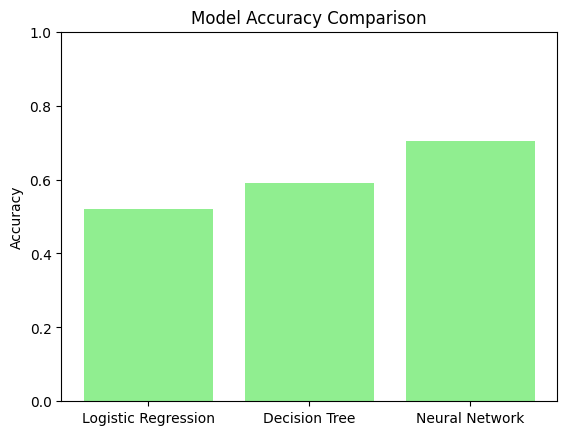

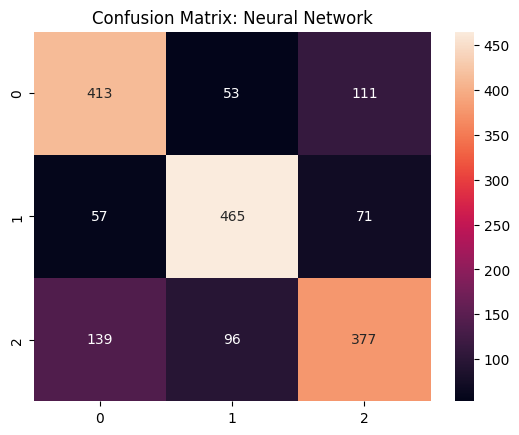

In [12]:

# Accuracy Bar Chart
accs = {name: results[name]["accuracy"] for name in results}
plt.bar(accs.keys(), accs.values(), color="lightgreen")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Confusion Matrix of Best Model
import seaborn as sns

best_model = max(accs, key=accs.get)
cm = results[best_model]["conf_matrix"]
sns.heatmap(cm, annot=True, fmt='d')
plt.title(f"Confusion Matrix: {best_model}")
plt.show()
